In [1]:
! pip install transformers 
! pip install tensorflow_addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd 
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from transformers import AutoTokenizer,AutoModel ,BertTokenizer , TFBertModel , PreTrainedTokenizerFast , TFAutoModel
from ast import literal_eval
import warnings 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
pd.set_option("display.max_info_columns", 200)

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on GPU
N_REPLICAS: 1


`NBME - Score Clinical Patient Notes`

`**Overiew of the Problem Statement :**`

Currently, physicians score patient note exams, which is a time and resource-intensive
process. The proposed solution will help overcome the practical barriers in patient note
scoring, making the approach more transparent and interpretable. It will also help ease the
development and administration of assessments, enabling medical practitioners to explore the
full potential of patient notes in revealing information relevant to clinical skills assessment.
The main challenge lies in the variability of expressions for different clinical concepts in
patient notes. For instance, &quot;loss of interest in activities&quot; may be expressed as &quot;no longer
plays tennis.&quot; Another challenge is to identify ambiguous negation cases such as &quot;no cold
intolerance, hair loss, palpitations, or tremor,&quot; which correspond to the key essential &quot;lack of
other thyroid symptoms.&quot;
What dataset(s) will you use? We will use a dataset of clinical patient notes written by medical
students, along with the corresponding exam rubrics. This dataset is provided by the National
Board of Medical Examiners (NBME).:


Below are the dataset we are using for the problem statemt:

`** patient_notes.csv **`- 
 
Text detailing important information related by the patient during the encounter (physical exam and interview).

Below are field related to patient notes 

 pn_num - A unique identifier for each patient note.

 case_num - A unique identifier for the clinical case a patient note represents.

 pn_history - The text of the encounter as recorded by  the test taker.


`** features.csv **`

A clinically relevant concept. A rubric describes the key concepts relevant to each case.


feature_num - A unique identifier for each feature.

case_num - A unique identifier for each case.

feature_text - A description of the feature.

`**train.csv**`


Training dataset 

pn_num - The patient note annotated in this row.

feature_num - The feature annotated in this row.

case_num - The case to which this patient note belongs.

annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.

location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon .

In [3]:
class config:
    MAX_LEN = 128 # intially we set it as 128 as default but it will overlayyed later  
    EPOCHS = 4
    DROPOUT = 0.4
    LEARNING_RATE = 1e-5
    BATCH_SIZE = 4

In [4]:
bert_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
bert_model = TFAutoModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [5]:
BASE_PATH = "../input/nbme-score-clinical-patient-notes/"
features_df = pd.read_csv(BASE_PATH + "features.csv")
patient_notes_df = pd.read_csv(BASE_PATH + "patient_notes.csv")
train_df = pd.read_csv(BASE_PATH + "train.csv")



In [6]:
df = pd.merge(train_df, features_df, on=['feature_num','case_num'], how='inner')
df =pd.merge(df, patient_notes_df, on=['pn_num','case_num'], how='inner')
df.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded,HPI: 17yo M presents with palpitations. Patien...


In [7]:
pd.set_option("display.max_info_columns", 200)

In [8]:
df.iloc[0,:].values

array(['00016_000', 0, 16, 0, "['dad with recent heart attcak']",
       "['696 724']",
       'Family-history-of-MI-OR-Family-history-of-myocardial-infarction',
       'HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights

In [9]:
# always use literal_eval instead of eval https://nedbatchelder.com/blog/201206/eval_really_is_dangerous.html
df["annotation"] = [literal_eval(x) for x in df["annotation"]] 
df["location"] = [literal_eval(x) for x in df["location"]]

In [10]:
pn_history_lengths = []
tk0 = tqdm(df['pn_history'].fillna("").values, total=len(df))
for text in tk0:
    length = bert_tokenizer.encode(text,add_special_tokens=False)
        
    pn_history_lengths.append(len(length))
print(f'pn_history max(lengths): {max(pn_history_lengths)}')


features_lengths=[]
tk1 = tqdm(df['feature_text'].fillna("").values, total=len(df))
for text in tk1:
    length = bert_tokenizer.encode(text,add_special_tokens=False)
    features_lengths.append(len(length))
print(f'feature_text  max(lengths): {max(features_lengths)}')

max_lenght= max(pn_history_lengths) + max(features_lengths) + 3 # cls & sep & sep
# set the max_lenght based on the max data we have 
config.MAX_LEN=max_lenght

print(f"max_len: {config.MAX_LEN}")

  0%|          | 0/14300 [00:00<?, ?it/s]

pn_history max(lengths): 390


  0%|          | 0/14300 [00:00<?, ?it/s]

feature_text  max(lengths): 30
max_len: 423


In [11]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:  
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


In [12]:
def classLabeling(pn_history, feature_text, annotation, location, tokenizer, max_len):    ##X , Y, selected_text  
    

    location_list = loc_list_to_ints(location)   # convert the locations into a list 

    char_targets = [0] * len(pn_history)  # creation of character taragert you can reason below 

    for loc,anno in zip(location_list ,annotation):        
        
        len_st = int(loc[1]) - int(loc[0])
        idx0 = None
        idx1 = None        
        for ind in (i for i, e in enumerate(pn_history) if (e == anno[0] and i == int(loc[0]))): # Only if the annotation start with character we are interested and look and character annotation postion match go inside the loop
        
            if pn_history[ind: ind+len_st] == anno.strip():

                idx0 = ind
                idx1 = ind + len_st - 1
                if idx0 != None and idx1 != None:
                    for ct in range(idx0, idx1 + 1): # make character targets as "1" for them 
                        char_targets[ct] = 1 
                break
    # Tokenize the data and here we are returing the offstes which we gone use as labels which you can find below 
    tokenized_input = bert_tokenizer.encode_plus(feature_text,pn_history,return_attention_mask=True,
                                                  return_offsets_mapping=True,return_token_type_ids=True)
    
    input_ids = tokenized_input['input_ids']
    mask = tokenized_input['attention_mask']
    token_type_ids = tokenized_input['token_type_ids']
    offsets = tokenized_input['offset_mapping']
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(offsets): # look for offsets 
        if sum(char_targets[offset1: offset2]) > 0: # if the lenght of the char_target for particualr target is greater than 0 then added one at that offsets 
            target_idx.append(j)
            
    #padding
    padding_length = config.MAX_LEN - len(input_ids) # Since we used 312 as max_lenght incase if we less lenght we need to pad the zeros 
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)
       
    #creating label
    ignore_idxes = np.where(np.array(token_type_ids) != 1)[0] # Bascially we use token type ids Segment token indices to indicate first and second portions of the input

    label = np.zeros(len(offsets))
    label[ignore_idxes] = 0.0 # creating a labels zero for not interested to look 
    label[target_idx] = 1.0  # label for which we are interested to look
    return {
    'ids': input_ids,
    'mask': mask,
    'token_type_ids': token_type_ids,
    'labels': label,
    'offsets': offsets
}

In [13]:

# define the tokenizer and max length
tokenizer = bert_tokenizer
max_len = config.MAX_LEN

print(max_len)

# define the function to create the dataset
def create_dataset(data):
    # create empty lists to store inputs and labels
    ids, masks, token_types, labels = [], [], [], []

    for index,row in data.iterrows():

        # extract the inputs and labels using classLabeling function
        inputs = classLabeling(row['pn_history'], row['feature_text'], 
                               row['annotation'], row['location'], 
                               tokenizer, max_len)

        # append the inputs and labels to the respective lists
        ids.append(inputs['ids'])
        masks.append(inputs['mask'])
        token_types.append(inputs['token_type_ids'])
        labels.append(inputs['labels'])

    # convert the lists to numpy arrays
    ids = np.array(ids)
    attention_masks = np.array(masks)
    token_type_ids = np.array(token_types)
    labels = np.array(labels)


    return {"ids":ids,"mask": attention_masks,"token_type_ids":token_type_ids},labels


423


In [14]:
# create df dataset
train_df = df.iloc[:int(0.8*len(df)),:]
val_df   = df.iloc[int(0.8*len(df)):,:]

In [15]:
train_data , train_labels =create_dataset(train_df)
val_data , val_labels = create_dataset(val_df)

In [16]:
# metrics
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,config.MAX_LEN))
        y_pred = tf.reshape(y_pred, (-1,config.MAX_LEN))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()
    

In [17]:
with strategy.scope():
    # METRICS
    model_metrics = [
        tf.keras.metrics.Precision(name='precision', thresholds=0.5),
        tf.keras.metrics.Recall(name='recall', thresholds=0.5),
        F1Score(),
    ]

In [18]:
def create_bert_model(hidden_size=100,dropout=config.DROPOUT,learning_rate=config.LEARNING_RATE):


    input_ids = tf.keras.layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(config.MAX_LEN,), dtype=tf.int32)
     

    bert_out = bert_model(input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids).last_hidden_state

    cls_token = bert_out

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    output = tf.keras.layers.Dense(1,activation='sigmoid')(hidden)
    
    model = tf.keras.Model(inputs=[input_ids,token_type_ids,attention_mask], outputs=[output])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=model_metrics)
    
    return model


In [19]:
model = create_bert_model()

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 423)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 423)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 423)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_3[0][0]                

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # look at val before we stop the training 
    min_delta=1e-5,  #  if min_delta is set to 0.001 and the monitored quantity is validation loss, then if the validation loss decreases by less than 0.001 from the previous epoch, it will not be considered as an improvement, and the EarlyStopping callback will wait for more significant improvements before stopping the training.
    patience=2, # patience refers to the number of epochs the training process can continue without improvement in the monitored quantity (e.g., validation loss or accuracy) before the training process is stopped.
    verbose=1, # logging messages printed to the console at the end of each epoch
    mode='auto', # to decrese the loss 
    restore_best_weights=True # to save best weights
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # look at val loss 
    factor=0.01,  # factor the learning rate to be decereased 
    patience=2,  # no.of epochs to be monitored 
    mode='auto', # to decrease loss 
    min_delta=0.001, # #  if min_delta is set to 0.001 and the monitored quantity is validation loss, then if the validation loss decreases by less than 0.001 from the previous epoch, it will not be considered as an improvement.
    verbose = 1
)

In [22]:
model_history = model.fit(
    (train_data['ids'],train_data['token_type_ids'], train_data['mask']),
    train_labels,
    validation_data=((val_data['ids'],val_data['token_type_ids'],val_data['mask']), val_labels),
    batch_size=config.BATCH_SIZE,
    epochs=config.EPOCHS,
    callbacks = [early_stop, reduce_lr]
)  

Epoch 1/4
2860/2860 [==============================] - 767s 265ms/step - loss: 0.0191 - precision: 0.5396 - recall: 0.4296 - f1: 0.4784 - val_loss: 0.0087 - val_precision: 0.7091 - val_recall: 0.5823 - val_f1: 0.6395
Epoch 2/4
2860/2860 [==============================] - 757s 265ms/step - loss: 0.0085 - precision: 0.8087 - recall: 0.6992 - f1: 0.7500 - val_loss: 0.0090 - val_precision: 0.7529 - val_recall: 0.6151 - val_f1: 0.6770
Epoch 3/4
2860/2860 [==============================] - 757s 265ms/step - loss: 0.0065 - precision: 0.8287 - recall: 0.7812 - f1: 0.8043 - val_loss: 0.0091 - val_precision: 0.6893 - val_recall: 0.7311 - val_f1: 0.7096
Restoring model weights from the end of the best epoch.

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-08.
Epoch 00003: early stopping


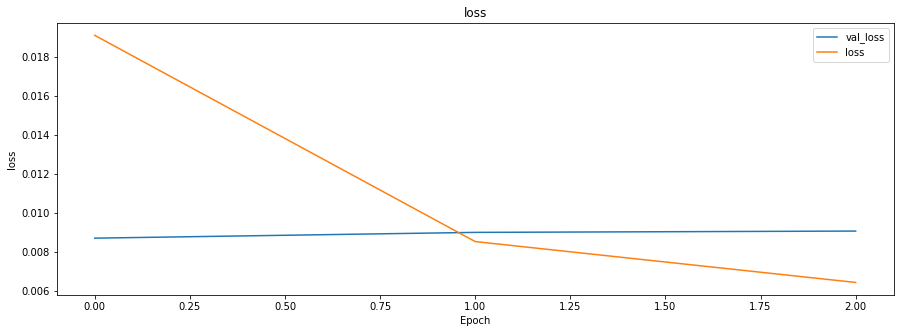

In [23]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history.epoch[-1]+1),model_history.history['val_loss'],label='val_loss')
plt.plot(range(model_history.epoch[-1]+1),model_history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

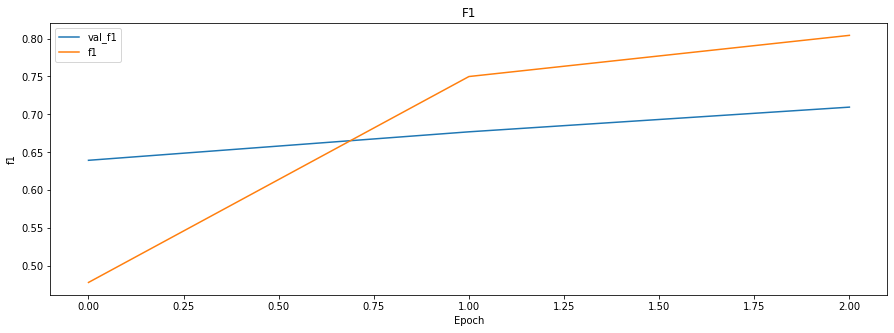

In [24]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history.epoch[-1]+1),model_history.history['val_f1'],label='val_f1')
plt.plot(range(model_history.epoch[-1]+1),model_history.history['f1'],label='f1')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('f1');plt.legend(); 
plt.show()

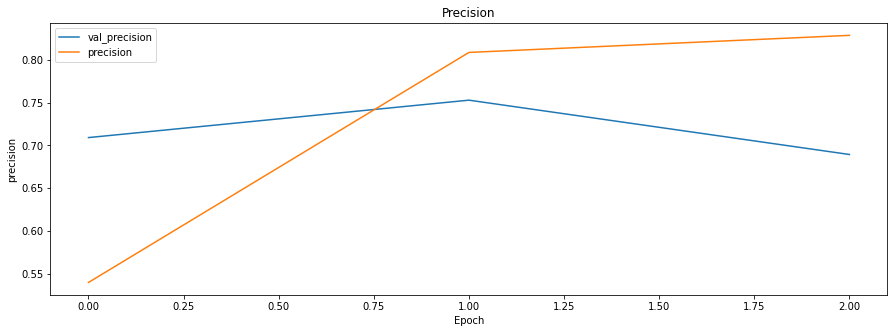

In [25]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history.epoch[-1]+1),model_history.history['val_precision'],label='val_precision')
plt.plot(range(model_history.epoch[-1]+1),model_history.history['precision'],label='precision')
plt.title('Precision'); plt.xlabel('Epoch'); plt.ylabel('precision');plt.legend(); 
plt.show()

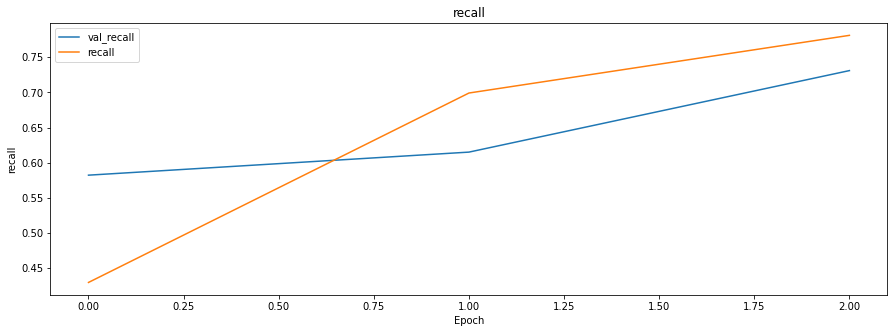

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(model_history.epoch[-1]+1),model_history.history['val_recall'],label='val_recall')
plt.plot(range(model_history.epoch[-1]+1),model_history.history['recall'],label='recall')
plt.title('recall'); plt.xlabel('Epoch'); plt.ylabel('recall');plt.legend(); 
plt.show()